In [141]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
raw_data = pd.read_csv('master.csv')

In [209]:
def data_clean(raw_data, drop_cols):
    # remove HDI for year because it contains too many missing values
    cleaned_data = raw_data.drop(columns=drop_cols)
    # convert gdp to int
    cleaned_data['gdp_for_year'] = cleaned_data[' gdp_for_year ($) '].apply(lambda x: int(''.join(x.split(','))))
    cleaned_data.drop(' gdp_for_year ($) ', axis=1, inplace=True)

    return cleaned_data

def feature_engi(cleaned_data, lags=6):
    # lags
    # sort values
    cleaned_data = cleaned_data.sort_values(['year', 'country', 'age', 'sex'])
    for i in range(1, lags):
        cleaned_data[f'lag_{i}'] = cleaned_data.groupby(['country', 'age', 'sex'])['suicides_no'].shift(i)
    # lag stats
    lag_cols = cleaned_data.columns[cleaned_data.columns.str.match('lag_*')]
    cleaned_data['lag_mean'] = cleaned_data[lag_cols].mean(axis=1)
    cleaned_data['lag_std'] = cleaned_data[lag_cols].std(axis=1)
    cleaned_data['lag_sum'] = cleaned_data[lag_cols].sum(axis=1)

    return cleaned_data

def data_encode(cleaned_data, age_group_map, one_hot_cols):
    # map age group
    cleaned_data['age'] = cleaned_data['age'].map(age_group_map)
    # one hot encode
    encoded_df = pd.get_dummies(cleaned_data, columns=one_hot_cols, drop_first=True)
    encoded_df.fillna(0, inplace=True)

    return encoded_df

def k_fold_features(train_set, test_set, target_col):
    # encode country using mean encoding
    country_map = train_set.groupby('country')[target_col].mean().to_dict()
    train_set.loc[:, 'country'] = train_set['country'].map(country_map)
    test_set.loc[:, 'country'] = test_set['country'].map(country_map)
    test_set.fillna(0, inplace=True)

    return train_set, test_set

def k_fold_split(cleaned_data, test_ym, lag=1, target_col='suicides_no'):
    for ym in test_ym:
        test_set = cleaned_data.loc[cleaned_data['year'] == ym]
        train_set = cleaned_data.loc[cleaned_data['year'] <= (ym - lag)]
        train_set, test_set = k_fold_features(train_set, test_set, target_col)
        y_train = train_set[target_col]
        X_train = train_set.drop(target_col, axis=1)
        y_test = test_set[target_col]
        X_test = test_set.drop(target_col, axis=1)

        yield X_train, y_train, X_test, y_test

def draw_feature_importance(reg, features):
    plt.figure(figsize=(10, 30))
    sns.barplot(y=features, x=reg.feature_importances_)

def train_reg(cleaned_data, reg, test_ym, draw_importance=True, **kwargs):
    mse_lst = []
    for X_train, y_train, X_test, y_test in k_fold_split(cleaned_data, test_ym):
        print('training set: year {} to {}, validation set: year {} to {}'.format(X_train.year.min(), X_train.year.max(), X_test.year.min(), X_test.year.max()))
        regressor = reg(**kwargs)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        valid_mse = mean_squared_error(y_test, y_pred)
        training_mse = mean_squared_error(y_train, regressor.predict(X_train))
        mse_lst.append(valid_mse)

        print('the validation mse is: {}'.format(valid_mse))
        print('the training mse is: {}'.format(training_mse))
        print('-' * 40)

    print('the mean validation mse is : {}'.format(np.mean(mse_lst)))

    if draw_importance:
        draw_feature_importance(regressor, X_train.columns)

    return regressor

In [210]:
one_hot_cols = ['sex', 'generation']
drop_cols = ['HDI for year', 'suicides/100k pop', 'country-year']
age_group_map = {
    '5-14 years': 0,
    '15-24 years': 1,
    '25-34 years': 2,
    '35-54 years': 3,
    '55-74 years': 4,
    '75+ years': 5
}

In [211]:
cleaned_data = data_clean(raw_data, drop_cols)
cleaned_data = feature_engi(cleaned_data)
cleaned_data = data_encode(cleaned_data, age_group_map, one_hot_cols)

training set: year 1985 to 2013, validation set: year 2014 to 2014


/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/frame.py:4468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


the validation mse is: 2648.299914613011
the training mse is: 1439.5504346685489
----------------------------------------
training set: year 1985 to 2014, validation set: year 2015 to 2015


/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/frame.py:4468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


the validation mse is: 2333.617346475508
the training mse is: 1422.9195584914382
----------------------------------------
training set: year 1985 to 2015, validation set: year 2016 to 2016


/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/frame.py:4468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


the validation mse is: 516.0978502083333
the training mse is: 1462.9704642978231
----------------------------------------
the mean validation mse is : 1832.6717037656174


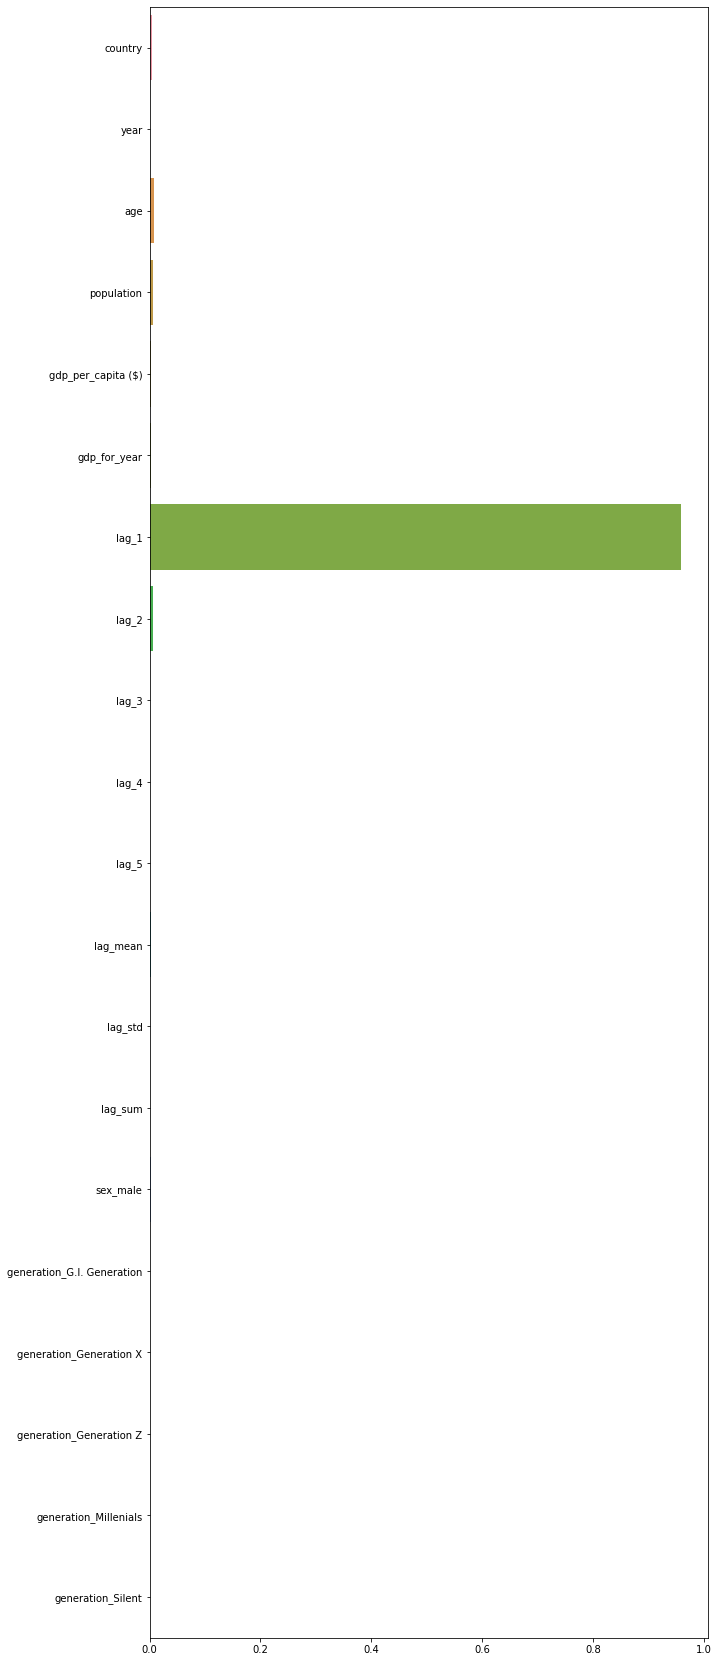

In [212]:
# Random Forest Reg
params = {
    'random_state': 16,
    'n_jobs': 4,
    'n_estimators': 300,
}
reg = train_reg(cleaned_data, RandomForestRegressor, [2014, 2015, 2016], **params)

In [224]:
# Remove generation according to feature importance
extra_cols = list(cleaned_data.columns[cleaned_data.columns.str.match('generation_*')])
df_filtered = cleaned_data.drop(extra_cols, axis=1)

training set: year 1985 to 2013, validation set: year 2014 to 2014


/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/frame.py:4468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


the validation mse is: 2604.4486017212735
the training mse is: 1428.8908195321185
----------------------------------------
training set: year 1985 to 2014, validation set: year 2015 to 2015


/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/frame.py:4468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


the validation mse is: 2250.1306525686973
the training mse is: 1433.7788886304725
----------------------------------------
training set: year 1985 to 2015, validation set: year 2016 to 2016


/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/zhuzhaoyang/miniconda3/envs/rl-algo/lib/python3.7/site-packages/pandas/core/frame.py:4468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


the validation mse is: 511.0528232638888
the training mse is: 1436.0479136285849
----------------------------------------
the mean validation mse is : 1788.5440258512865


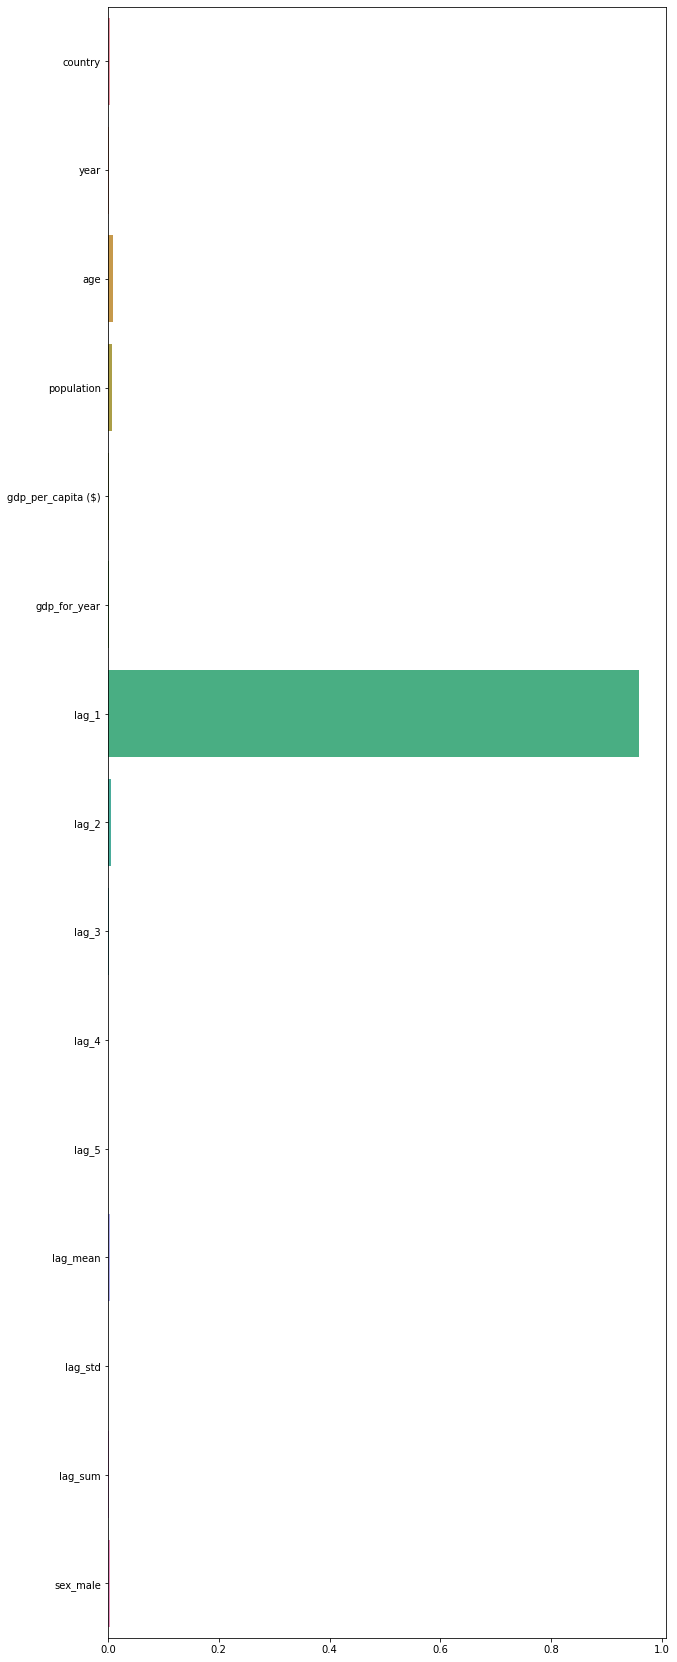

In [225]:
reg_filtered = train_reg(df_filtered, RandomForestRegressor, [2014, 2015, 2016], **params)